## Assignment

In this assignment, you keep working with the Students Performance in Exams dataset from Kaggle. You should access the data from the Thinkful database. Here's the credentials you can use to connect to the database:

postgres_user = 'dsbc_student'<br>
postgres_pw = '7\*.8G9QH21'<br>
postgres_host = '142.93.121.174'<br>
postgres_port = '5432'<br>
postgres_db = 'studentsperformance'<br>

To complete this assignment, submit a link to a Jupyter notebook containing your solutions to the following tasks:

1. Are there any differences between the genders, ethnicities, and parental level of education with respect to their performances in exams?
2. Are there any differences between the lunch types with respect to their performances in exams? If there are, how do you explain this?
3. Does the test preparation course seem to have an effect on the exam performances?
4. Which 2 exam scores are most correlated with each other?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import pandas_profiling
from sqlalchemy import create_engine
import warnings 

warnings.filterwarnings('ignore')

In [3]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'studentsperformance'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

stu = pd.read_sql_query('select * from studentsperformance',con=engine)

engine.dispose()

stu.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


In [13]:
stu.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
gender                         1000 non-null object
race/ethnicity                 1000 non-null object
parental level of education    1000 non-null object
lunch                          1000 non-null object
test preparation course        1000 non-null object
math score                     1000 non-null int64
reading score                  1000 non-null int64
writing score                  1000 non-null int64
dtypes: int64(3), object(5)
memory usage: 62.6+ KB


### 1. Are there any differences between the genders, ethnicities, and parental level of education with respect to their performances in exams?

There are differences between different groups in terms of student performance. To test if they are significant, t-test and one-way ANOVA were used.

In [74]:
scores = ['math score', 'reading score', 'writing score']

In [6]:
stu.groupby('gender').mean()

,math score,reading score,writing score
gender,,,
female,63.633205,72.608108,72.467181
male,68.728216,65.473029,63.311203


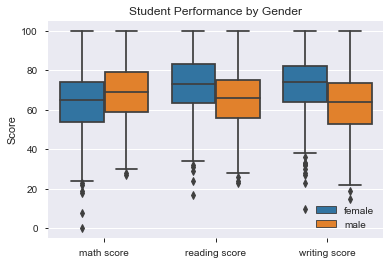

In [96]:
var1 = stu[['math score', 'reading score', 'writing score', 'gender']]

ax1 = sns.boxplot(x='variable', y="value", hue='gender', data=pd.melt(var1, 'gender'))
plt.ylabel("Score")
plt.xlabel("")
plt.legend(loc="lower right")
plt.title("Student Performance by Gender")

plt.show()

In [12]:
#t-test
gender = stu['gender'].unique()
gen_stu = stu.groupby('gender')

for var in scores:
    print("----------------------------------------------------")
    print("Comparison for variable: {}".format(var))
    #print("----------------------------------------------------")
    
    for i in range(0,len(gender)):
        for j in range(i+1, len(gender)):
            print("t-test between groups {0} and {1}:".format(gender[i], gender[j]))
            print(stats.ttest_ind(
                stu[stu['gender']==gender[i]][var],
                stu[stu['gender']==gender[j]][var]
            ))

----------------------------------------------------
Comparison for variable: math score
t-test between groups female and male:
Ttest_indResult(statistic=-5.383245869828983, pvalue=9.120185549328822e-08)
----------------------------------------------------
Comparison for variable: reading score
t-test between groups female and male:
Ttest_indResult(statistic=7.959308005187657, pvalue=4.680538743933289e-15)
----------------------------------------------------
Comparison for variable: writing score
t-test between groups female and male:
Ttest_indResult(statistic=9.979557910004507, pvalue=2.019877706867934e-22)


+ Gender: differences in student performance are all statistically significant. Male students perform better in math while female students perform better in reading and writing. 

In [7]:
stu.groupby('race/ethnicity').mean()

,math score,reading score,writing score
race/ethnicity,,,
group A,61.629213,64.674157,62.674157
group B,63.452632,67.352632,65.600000
group C,64.463950,69.103448,67.827586
group D,67.362595,70.030534,70.145038
group E,73.821429,73.028571,71.407143


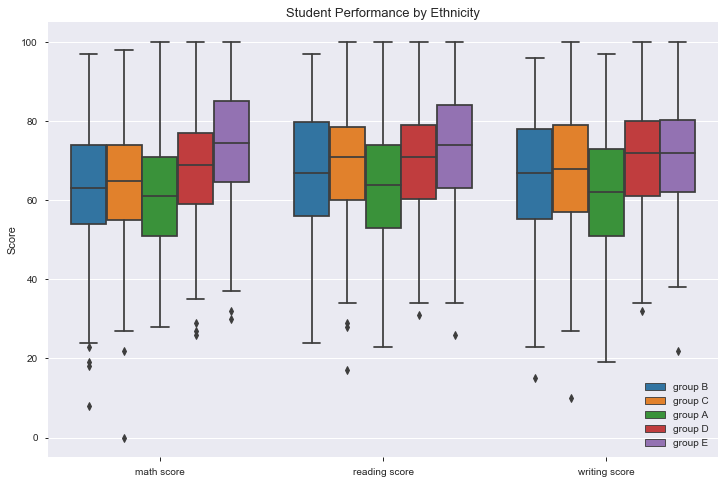

In [94]:
var2 = stu[['math score', 'reading score', 'writing score', 'race/ethnicity']]

plt.figure(figsize=(12,8))
ax1 = sns.boxplot(x='variable', y="value", hue='race/ethnicity', data=pd.melt(var2, 'race/ethnicity'))
plt.ylabel("Score")
plt.xlabel("")
plt.legend(loc="lower right", fontsize=10)
plt.title("Student Performance by Ethnicity", fontsize=13)

plt.show()

Since there are more than two groups, I conducted one-way ANOVA first, and then followed by pairwise t-tests.

In [80]:
#Hobson: is it better to do ANOVA first and then if it's significant, followed by pairwise comparison 
#than pairwise t-tests directly? 

race = stu['race/ethnicity'].unique()

for score in scores:
    print("Comparison for: {}".format(score))
    print(stats.f_oneway(stu[score][stu['race/ethnicity'] == race[0]],
                         stu[score][stu['race/ethnicity'] == race[1]],
                         stu[score][stu['race/ethnicity'] == race[2]],
                         stu[score][stu['race/ethnicity'] == race[3]],
                         stu[score][stu['race/ethnicity'] == race[4]]))   

Comparison for: math score
F_onewayResult(statistic=14.593885166332637, pvalue=1.3732194030370688e-11)
Comparison for: reading score
F_onewayResult(statistic=5.621659307419644, pvalue=0.0001780089103235947)
Comparison for: writing score
F_onewayResult(statistic=7.162415174347505, pvalue=1.0979189070067382e-05)


Since there are significant differences among race/ethnicity groups, I conduct pairwise t-tests to find out where the differences are. As we can see, some of them are significant and some are not with alpha at 0.05. 

In [78]:
#t-test
for var in scores:
    print("----------------------------------------------------")
    print("Comparison for variable: {}".format(var))
    print("----------------------------------------------------")
    
    for i in range(0,len(race)):
        for j in range(i+1, len(race)):
            print("t-test between groups {0} and {1}:".format(race[i], race[j]))
            print(stats.ttest_ind(
                stu[stu['race/ethnicity']==race[i]][var],
                stu[stu['race/ethnicity']==race[j]][var]
            ))

----------------------------------------------------
Comparison for variable: math score
----------------------------------------------------
t-test between groups group B and group C:
Ttest_indResult(statistic=-0.7315669893534263, pvalue=0.4647708939167453)
t-test between groups group B and group A:
Ttest_indResult(statistic=0.9355076279747488, pvalue=0.3503415961659957)
t-test between groups group B and group D:
Ttest_indResult(statistic=-2.82845539712675, pvalue=0.004886197137104194)
t-test between groups group B and group E:
Ttest_indResult(statistic=-6.007397050552227, pvalue=5.007946047497971e-09)
t-test between groups group C and group A:
Ttest_indResult(statistic=1.5997220303217299, pvalue=0.11043810745588042)
t-test between groups group C and group D:
Ttest_indResult(statistic=-2.41858624746011, pvalue=0.015888349556016285)
t-test between groups group C and group E:
Ttest_indResult(statistic=-6.127642520822135, pvalue=1.927238849552764e-09)
t-test between groups group A and gr

In [8]:
stu.groupby('parental level of education').mean()

,math score,reading score,writing score
parental level of education,,,
associate's degree,67.882883,70.927928,69.896396
bachelor's degree,69.389831,73.000000,73.381356
high school,62.137755,64.704082,62.448980
master's degree,69.745763,75.372881,75.677966
some college,67.128319,69.460177,68.840708
some high school,63.497207,66.938547,64.888268


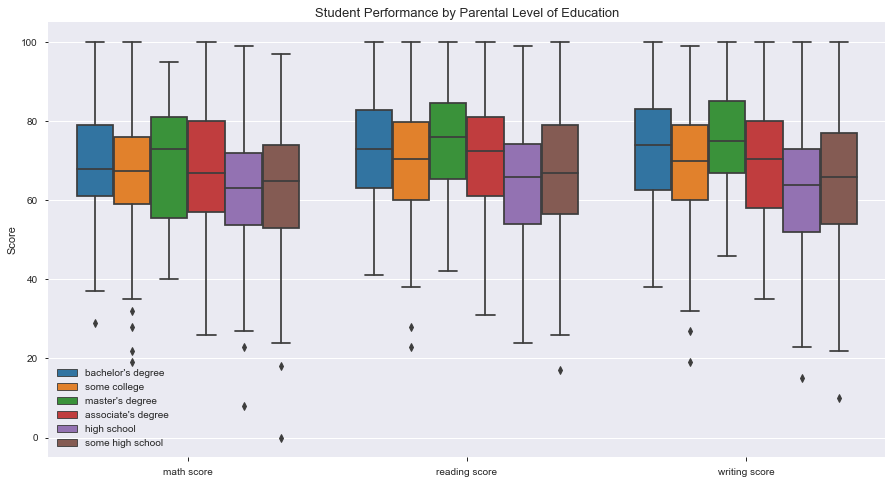

In [93]:
var3 = stu[['math score', 'reading score', 'writing score', 'parental level of education']]

plt.figure(figsize=(15,8))
ax1 = sns.boxplot(x='variable', y="value", hue='parental level of education', data=pd.melt(var3, 'parental level of education'))
plt.ylabel("Score")
plt.xlabel("")
plt.legend(loc="lower left", fontsize=10)
plt.title("Student Performance by Parental Level of Education", fontsize=13)

plt.show()

Similar as race and ethnicity, since there are more than two groups, I conduct one-way ANOVA first and then followed by pairwise t-tests.

In [81]:
paredu = stu['parental level of education'].unique()

for score in scores:
    print("Comparison for: {}".format(score))
    print(stats.f_oneway(stu[score][stu['parental level of education'] == paredu[0]],
                         stu[score][stu['parental level of education'] == paredu[1]],
                         stu[score][stu['parental level of education'] == paredu[2]],
                         stu[score][stu['parental level of education'] == paredu[3]],
                         stu[score][stu['parental level of education'] == paredu[4]]))

Comparison for: math score
F_onewayResult(statistic=6.711561302090129, pvalue=2.571851970804558e-05)
Comparison for: reading score
F_onewayResult(statistic=10.684699154443775, pvalue=1.9176152973005756e-08)
Comparison for: writing score
F_onewayResult(statistic=16.033769289676428, pvalue=1.2051245369064163e-12)


Since there are significant differences among race/ethnicity groups, I conduct pairwise t-tests to find out where the differences are. As we can see, some of them are significant and some are not with alpha at 0.05. In general, for all subjects, students whose parents have a master's degree perform the best, while students whose parents have a high school degree perfom the worst. 

In [82]:
#t-test
for var in scores:
    print("----------------------------------------------------")
    print("Comparison for variable: {}".format(var))
    print("----------------------------------------------------")
    
    for i in range(0,len(paredu)):
        for j in range(i+1, len(paredu)):
            print("t-test between groups {0} and {1}:".format(paredu[i], paredu[j]))
            print(stats.ttest_ind(
                stu[stu['parental level of education']==paredu[i]][var],
                stu[stu['parental level of education']==paredu[j]][var]
            ))

----------------------------------------------------
Comparison for variable: math score
----------------------------------------------------
t-test between groups bachelor's degree and some college:
Ttest_indResult(statistic=1.3702352829617477, pvalue=0.17151224218471559)
t-test between groups bachelor's degree and master's degree:
Ttest_indResult(statistic=-0.14868196568849312, pvalue=0.8819757824867702)
t-test between groups bachelor's degree and associate's degree:
Ttest_indResult(statistic=0.8786641889793243, pvalue=0.38020757818036177)
t-test between groups bachelor's degree and high school:
Ttest_indResult(statistic=4.236143622484822, pvalue=2.9965345853843376e-05)
t-test between groups bachelor's degree and some high school:
Ttest_indResult(statistic=3.196718602676573, pvalue=0.0015409192922812146)
t-test between groups some college and master's degree:
Ttest_indResult(statistic=-1.2356334215824571, pvalue=0.21761956810347416)
t-test between groups some college and associate's 

### 2. Are there any differences between the lunch types with respect to their performances in exams? If there are, how do you explain this?

As we can see from the t-test results, all differences are statistically significant, indicating, students with standard lunch perform better than students with reduced lunch. Becasue lunch type is always used as an indicator of socialeconomic status (SES), it means students with higher SES perform better. 

In [83]:
stu.groupby('lunch').mean()

,math score,reading score,writing score
lunch,,,
free/reduced,58.921127,64.653521,63.022535
standard,70.034109,71.654264,70.823256


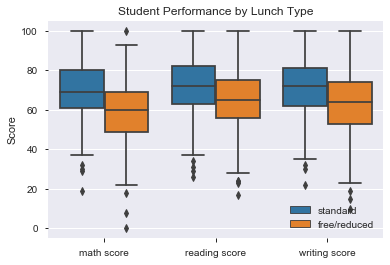

In [91]:
var4 = stu[['math score', 'reading score', 'writing score', 'lunch']]

ax1 = sns.boxplot(x='variable', y="value", hue='lunch', data=pd.melt(var4, 'lunch'))
plt.ylabel("Score")
plt.xlabel("")
plt.legend(loc="lower right")
plt.title("Student Performance by Lunch Type")

plt.show()

In [85]:
lunch = stu['lunch'].unique()
for var in scores:
    print("----------------------------------------------------")
    print("Comparison for variable: {}".format(var))
    print("----------------------------------------------------")
    
    for i in range(0,len(lunch)):
        for j in range(i+1, len(lunch)):
            print("t-test between groups {0} and {1}:".format(lunch[i], lunch[j]))
            print(stats.ttest_ind(
                stu[stu['lunch']==lunch[i]][var],
                stu[stu['lunch']==lunch[j]][var]
            ))

----------------------------------------------------
Comparison for variable: math score
----------------------------------------------------
t-test between groups standard and free/reduced:
Ttest_indResult(statistic=11.837180472914612, pvalue=2.4131955993137074e-30)
----------------------------------------------------
Comparison for variable: reading score
----------------------------------------------------
t-test between groups standard and free/reduced:
Ttest_indResult(statistic=7.451056467473455, pvalue=2.0027966545279011e-13)
----------------------------------------------------
Comparison for variable: writing score
----------------------------------------------------
t-test between groups standard and free/reduced:
Ttest_indResult(statistic=8.009784197834758, pvalue=3.186189583166477e-15)


### 3. Does the test preparation course seem to have an effect on the exam performances?

As we can see from t-test results, all differences are statistically significant, meaning students who completed prep course performed better than those who didn't. However, we can not conclude it is a causal effect because we don't know if students in each group is random. For further investigation, two methods can be considered:

+ run an experimental design with randomization 
+ use the same dataset but use propensity score matching to minize student differences in other variables (e.g., gender, ethnicity, parent education level)

In [88]:
stu.groupby('test preparation course').mean()

,math score,reading score,writing score
test preparation course,,,
completed,69.695531,73.893855,74.418994
none,64.077882,66.534268,64.504673


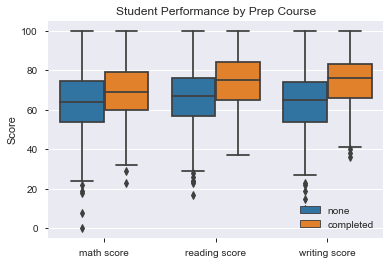

In [98]:
var5 = stu[['math score', 'reading score', 'writing score', 'test preparation course']]

ax1 = sns.boxplot(x='variable', y="value", hue='test preparation course', data=pd.melt(var5, 'test preparation course'))
plt.ylabel("Score")
plt.xlabel("")
plt.legend(loc="lower right")
plt.title("Student Performance by Prep Course")

plt.show()

In [90]:
prep = stu['test preparation course'].unique()
for var in scores:
    print("----------------------------------------------------")
    print("Comparison for variable: {}".format(var))
    print("----------------------------------------------------")
    
    for i in range(0,len(lunch)):
        for j in range(i+1, len(lunch)):
            print("t-test between groups {0} and {1}:".format(prep[i], prep[j]))
            print(stats.ttest_ind(
                stu[stu['test preparation course']==prep[i]][var],
                stu[stu['test preparation course']==prep[j]][var]
            ))

----------------------------------------------------
Comparison for variable: math score
----------------------------------------------------
t-test between groups none and completed:
Ttest_indResult(statistic=-5.704616417349102, pvalue=1.5359134607147415e-08)
----------------------------------------------------
Comparison for variable: reading score
----------------------------------------------------
t-test between groups none and completed:
Ttest_indResult(statistic=-7.871663538941468, pvalue=9.081783336892205e-15)
----------------------------------------------------
Comparison for variable: writing score
----------------------------------------------------
t-test between groups none and completed:
Ttest_indResult(statistic=-10.409173436808748, pvalue=3.68529173524572e-24)


### 4. Which 2 exam scores are most correlated with each other?

As we can see from both correlation matrix and its heatmap, reading and writing scores are most correlated (r=0.95).

In [105]:
stu.corr().round(2)

,math score,reading score,writing score
math score,1.00,0.82,0.80
reading score,0.82,1.00,0.95
writing score,0.80,0.95,1.00


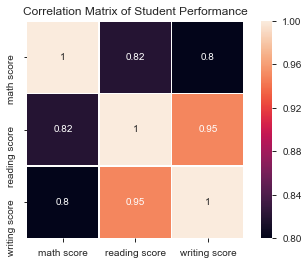

In [103]:
corr = stu.corr()
sns.heatmap(corr, square=True, annot=True, linewidths=.5)
plt.title("Correlation Matrix of Student Performance")

plt.show()